<p><a href="https://opencv.org/courses/"><img alt="OpenCV logo" height="45px" src="https://opencv.org/wp-content/uploads/2020/07/cropped-OpenCV_logo_white.png" align="left" style="width:80px;height:80px;"></a></p>   <h1>Computer Vision II: Applications (Python)</h1>  

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](FaceMaskDetector-YOLOv4.ipynb)

<h2>Project 3: Train a Face Mask Detector<h2>
    
PART 2/2

# Introduction

Train the object detector using YOLO v4 to recognize masks covering a human face.

YOLO &#8594; You Only Look Once  

Use this [HOWTO](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects) as a reference for training your model using YOLO v4 architecture and pre-trained model.

https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

# Notebook preparation

Review the following variable before starting this notebook.  

In [1]:
# Imports
# -------
import numpy as np
import cv2 as cv
import io, shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
#from ipythonblocks import ImageGrid, BlockGrid, colors
from google.colab import files, drive
from pathlib import Path

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,15.0)
#matplotlib.rcParams['image.cmap'] = 'gray'

This is the part of the code that you may want to modify. Check where you want to run **darknet** framework.  
It is recommended to run in persistent storage such as *Google Drive* to avoiding lost tem ongoing working in case of a *Kernel disconnect*.  
<BR>
Please, check the Combo Box below to load the **darknet** framework and **dataset** into your *Google Drive*.


In [3]:
# Initialization

# ----------- #
# Change HERE #
# ----------- #
USE_GOOGLE_DRIVE = True #@param {type:"boolean"}
google_drive_base_dir = '/content/drive/My Drive/' if USE_GOOGLE_DRIVE else '/tmp/'
darknet_drive = google_drive_base_dir + 'darknet/'
dataset_drive = google_drive_base_dir + 'dataset/'
test_ds_drive = dataset_drive + 'test/'           
training_ds_drive = dataset_drive + 'training/'   
# ----------- #
#  END        #
# ----------- #

Based on the directories defined above, the tree to compute the face mask detection will be created.

In [4]:
base_path = Path(google_drive_base_dir)
darknet_path = Path(darknet_drive)
dataset_path = Path(dataset_drive)
test_ds_path = Path(test_ds_drive)
train_ds_path = Path(training_ds_drive)

print('-- Working Directories --')
print(f'* BASE   : {base_path.as_posix()}')
print(f'* DARKNET: {darknet_path.as_posix()}')
print('\nDATASE :')
print(f'* TEST   : {test_ds_path.as_posix()}')
print(f'* TRAIN  : {train_ds_path.as_posix()}')

-- Working Directories --
* BASE   : /content/drive/My Drive
* DARKNET: /content/drive/My Drive/darknet

DATASE :
* TEST   : /content/drive/My Drive/dataset/test
* TRAIN  : /content/drive/My Drive/dataset/training


In [5]:
# Test data
test_images = [(test_ds_path.as_posix()+'/test-image1.jpg',
                'https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1'),
               (test_ds_path.as_posix()+'/test-image2.jpg',
                'https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1'),
               (test_ds_path.as_posix()+'/test-image3.jpg',
                'https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1'),
               (test_ds_path.as_posix()+'/test-image4.jpg',
                'https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1')]
test_videos = [(test_ds_path.as_posix()+'/test-video1.mp4',
                'https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1'),
               (test_ds_path.as_posix()+'/test-video2.mp4',
                'https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1')]

Working from a persistent environment.

In [6]:
if USE_GOOGLE_DRIVE:
  drive.mount('/content/drive')
  %cd {google_drive_base_dir}
%pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


'/content/drive/My Drive'

If you don't want to wipe out the darknet directory from your Google drive, skip the following line.

In [7]:
DELETE_DARKNET = False #@param {type:"boolean"}
if DELETE_DARKNET:
  print(f'Deleting {darknet_path}')
  darknet_path.rmdir()

## Installing required softwares

From pip source

In [ ]:
# not in use yet
#!pip install -q ipythonblocks

# DarkNet

You can skip this section if you already have **darknet** installed and built in your environment.

## Clone from Github

Clone **darknet** from GitHub.

In [ ]:
print('Downloading darknet to ' + darknet_drive)
!git clone https://github.com/AlexeyAB/darknet.git '{darknet_drive}'

## Compile DarkNet

In [ ]:
%%bash -s "$darknet_drive"
DARKNETDIR=$1
cd "$DARKNETDIR"
pwd

sed -i 's/OPENCV=0/OPENCV=1/' Makefile
sed -i 's/GPU=0/GPU=1/' Makefile
sed -i 's/CUDNN=0/CUDNN=1/' Makefile

echo "Building. . . It might take 2 minutes"

make &> build_log.txt

echo "Build completed, CONGRATS!!"

In [8]:
%%bash -s "$darknet_drive"
DARKNETDIR=$1
cd "$DARKNETDIR"
chmod u+x ./darknet
ls -l darknet

-rwx------ 1 root root 5609376 Jul 27 20:55 darknet


# YOLOv4

## Download YOLO v4 weights

For training cfg/yolov4-custom.cfg download the pre-trained weights-file (162 MB): [yolov4.conv.137](https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137) (Google drive mirror [yolov4.conv.137](https://drive.google.com/open?id=1JKF-bdIklxOOVy-2Cr5qdvjgGpmGfcbp))

In [ ]:
yolov4_weights = darknet_drive+'/yolov4.weights'
yolov4_weights_path = Path(yolov4_weights)

if yolov4_weights_path.exists():
    print('The YOLOv4 custom config was found in your darknet framework!')
else:
    !wget "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137" \
    -O "{yolov4_weights_path.as_posix()}"

The YOLOv4 custom config was found in your darknet framework!


## Prepare YOLO v4 custom configuration file  

Create file yolo-face.cfg with the same content as in yolov4-custom.cfg.

In [9]:
yolov4_custom_cfg = darknet_drive+'/cfg/yolov4-custom.cfg'
yolov4_mask_train_cfg = darknet_drive+'/cfg/yolov4-mask-train.cfg'
yolov4_mask_test_cfg = darknet_drive+'/cfg/yolov4-mask-test.cfg'

darknet_yolov4_custom_cfg_path = Path(yolov4_custom_cfg)
darknet_yolov4_mask_train_cfg_path = Path(yolov4_mask_train_cfg)
darknet_yolov4_mask_test_cfg_path = Path(yolov4_mask_test_cfg)

Modify on *yolov4-obj.cfg* file:
* change line *batch* to ```batch=64```
* change line *subdivisions* to ```subdivisions=16```
* change line *max_batches* to ```max_batches = 6000```
* change line *steps* to ```steps=4800,5400```
* set network size (*width* and *height*) to ```width=416``` and ```height=416```
* change line *classes* to ```classes=2``` in each of 3 **[yolo]** layers
* change line *filters* to ```filters=21``` in the 3 **[convolutional]** layer before each **[yolo]** layer

In [10]:
batch=64
subdivisions=48
max_batches=6000
steps="4800,5400"
width=416
height=416
classes=2
filters=21

In [ ]:
yolov4_mask_train_cfg = f"""[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch={batch}
subdivisions={subdivisions}
width={width}
height={height}
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = {max_batches}
policy=steps
steps=400000,450000
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-7

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-10

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=256
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-28

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=512
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-28

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-16

[convolutional]
batch_normalize=1
filters=1024
size=1
stride=1
pad=1
activation=mish
stopbackward=800

##########################

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

### SPP ###
[maxpool]
stride=1
size=5

[route]
layers=-2

[maxpool]
stride=1
size=9

[route]
layers=-4

[maxpool]
stride=1
size=13

[route]
layers=-1,-3,-5,-6
### End SPP ###

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = 85

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = 54

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

##########################

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filters}
activation=linear


[yolo]
mask = 0,1,2
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes={classes}
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
scale_x_y = 1.2
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5


[route]
layers = -4

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=256
activation=leaky

[route]
layers = -1, -16

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filters}
activation=linear


[yolo]
mask = 3,4,5
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes={classes}
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
scale_x_y = 1.1
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5


[route]
layers = -4

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=512
activation=leaky

[route]
layers = -1, -37

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filters}
activation=linear


[yolo]
mask = 6,7,8
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes={classes}
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1
scale_x_y = 1.05
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5
"""

print(f"Add YOLO v4 config file for trainning step {darknet_yolov4_mask_train_cfg_path.as_posix()}")
with open(darknet_yolov4_mask_train_cfg_path.as_posix(), 'wt') as f:
  f.write(yolov4_mask_train_cfg)  

Add YOLO v4 config file for trainning step /content/drive/My Drive/darknet/cfg/yolov4-mask-train.cfg


In [ ]:
yolov4_mask_test_cfg = f"""[net]
# Testing
batch=1
subdivisions=1
# Training
#batch={batch}
#subdivisions={subdivisions}
width={width}
height={height}
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = {max_batches}
policy=steps
steps=400000,450000
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-7

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-10

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=256
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-28

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=512
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-28

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-16

[convolutional]
batch_normalize=1
filters=1024
size=1
stride=1
pad=1
activation=mish
stopbackward=800

##########################

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

### SPP ###
[maxpool]
stride=1
size=5

[route]
layers=-2

[maxpool]
stride=1
size=9

[route]
layers=-4

[maxpool]
stride=1
size=13

[route]
layers=-1,-3,-5,-6
### End SPP ###

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = 85

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = 54

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

##########################

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filters}
activation=linear


[yolo]
mask = 0,1,2
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes={classes}
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
scale_x_y = 1.2
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5


[route]
layers = -4

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=256
activation=leaky

[route]
layers = -1, -16

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filters}
activation=linear


[yolo]
mask = 3,4,5
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes={classes}
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
scale_x_y = 1.1
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5


[route]
layers = -4

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=512
activation=leaky

[route]
layers = -1, -37

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={filters}
activation=linear


[yolo]
mask = 6,7,8
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes={classes}
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1
scale_x_y = 1.05
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5
"""

print(f"Add YOLO v4 config file for prediction {darknet_yolov4_mask_test_cfg_path.as_posix()}")
with open(darknet_yolov4_mask_test_cfg_path.as_posix(), 'wt') as f:
  f.write(yolov4_mask_test_cfg)  

Add YOLO v4 config file for prediction /content/drive/My Drive/darknet/cfg/yolov4-mask-test.cfg


Create file ```yolov4-mask-setup.data``` in the **darknet** directory, with the following information:

```
classes=2
train  = data_train.txt
valid = data_test.txt
names = class.names
backup = backup/
```

Create file ```class.names``` in the **darknet** directory, with object names - each in new line.


1.   Mask
2.   No Mask



In [ ]:
yolov4_mask_setup_data = """classes=2
train  = data_train.txt
valid = data_test.txt
names = class.names
backup = backup/
"""
class_names="Mask\nNO_Mask"

darnet_setup_fname = darknet_path.as_posix() + '/yolov4-mask-setup.data'
print(f"Add darknet's setup file {darnet_setup_fname}")
with open(darnet_setup_fname, 'wt') as f:
  f.write(yolov4_mask_setup_data)

darnet_class_fname = darknet_path.as_posix() + '/class.names'
print(f"Add darknet's class.names file {darnet_class_fname}")
with open(darnet_class_fname, 'wt') as f:
  f.write(class_names)  

Add darknet's setup file /content/drive/My Drive/darknet/yolov4-mask-setup.data
Add darknet's class.names file /content/drive/My Drive/darknet/class.names


In [11]:
yolo_shape = (448,448,3) # shape
s = 7

# Datasets 

## Training dataset

Downloading training dataset.

In [ ]:
if not dataset_path.exists():
  print('Adding dir ' + dataset_path.as_posix())
  dataset_path.mkdir(parents=True)

if not test_ds_path.exists():
  print('Adding dir ' + test_ds_path.as_posix())
  test_ds_path.mkdir(parents=True)

if not train_ds_path.exists():
  print('Adding dir ' + train_ds_path.as_posix())
  train_ds_path.mkdir(parents=True)

Download the dataset.

SKIP that if you've already done before.

In [ ]:
# ------- #
# DATASET #
# ------- #
dataset_file = train_ds_path.as_posix() + '/kaggle_and_no-mask_dataset.zip'
print('Dataset will be downloaded to ' + dataset_file)
!wget https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1 --output-document "{dataset_file}" --quiet
!unzip -qo "{dataset_file}" -d "{train_ds_path.as_posix()}"
!rm -v "{dataset_file}"

Creating the darknet config files based on training/validation files.

In [ ]:
def DataSetSplit(path='.', test_size=0.20, random_state=101):
    assert test_size < 1.0, "Test size must be lower than 1.0"
    path_dataset = Path(path)
    # every dataset element has a txt and a jpeg file.
    # from every txt file, find its jpeg sibling
    train_files = []
    test_files = []

    if not path_dataset.is_dir():
        return None, None

    # ignoring checking if there is a valid image file for each txt file
    all_txt = list(path_dataset.glob('*.txt'))

    test_set = int(len(all_txt) * test_size)

    random.seed(random_state)
    test_population = random.sample(range(len(all_txt)),test_set)

    for p in range(len(all_txt)):
        if p in test_population:
            test_files.append(all_txt[p])
        else:
            train_files.append(all_txt[p])

    return (train_files, test_files)

def DarknetGenTrainTest(train,test):
    def copy2file(outfname, test_set):
        with open(outfname, 'wt') as f:
            for t in test_set:
                t_path = Path(t)
                ppath = t_path.parent
                fname = t_path.stem
                im_fname = [ i.as_posix()  for i in list(ppath.glob(fname+'*')) if not i.match('*.txt') ]
                if len(im_fname) > 0:
                    f.write(im_fname[0] + '\n')

    data_train_fname = darknet_path.as_posix() + '/data_train.txt'
    data_test_fname = darknet_path.as_posix() + '/data_test.txt'
    print(f'Preparing {data_train_fname}')
    copy2file(data_train_fname, train)
    print(f'Preparing {data_test_fname}')
    copy2file(data_test_fname, test)

In [ ]:
train,test = DataSetSplit(train_ds_path.as_posix())
DarknetGenTrainTest(train,test)

## Test Images and Videos

Downloading test images and videos.

In [ ]:
for t_file in test_images + test_videos:
  print(f'Downloading {t_file[1]} -> {t_file[0]}')
  !wget {t_file[1]} --output-document "{t_file[0]}" --no-verbose

2020-07-30 09:45:39 URL:https://uc4e750867e66f433ff2bde09c73.dl.dropboxusercontent.com/cd/0/get/A8eal2xR5Q2LFj5VqiXXGFSFMF-ieMwLCCK0OtbYm3osvlp-MTo1aMn-UG_WvR5ubmGXWwxgihEPUiiG8yacn_dy9fBE_8Zjdt2d_A80EoenrZWiY11DekgPVy2mPozPwNs/file?dl=1 [316127/316127] -> "/content/drive/My Drive/dataset/test/test-image1.jpg" [1]
2020-07-30 09:45:41 URL:https://uc32c5e8bbb12c2fba7c80691829.dl.dropboxusercontent.com/cd/0/get/A8dSq5vB_IBTHSs7rQkCgGjRdlB_S6WKvB1U99-O3hBgUb4NczT9uTOq2t2ugQZucdvjgnGafKYet9_SN31906BczFogcLDOyE8T0I9_nCIZAnBMPDhnoLl2Ydtt8MzjikU/file?dl=1 [55982/55982] -> "/content/drive/My Drive/dataset/test/test-image2.jpg" [1]
2020-07-30 09:45:44 URL:https://uc025241af57570ae7cc01cb4a79.dl.dropboxusercontent.com/cd/0/get/A8cABdosqsPQtUeXC9ChgAvRbY-mJ44S0OUfA3NhOaqHfLcaU1s40O_4xHUC4Q6SpPaFF17QR53nvjw3lKSfg5n8d8dAdy0aqMu2VO0-NDQic13_xPOLg1IDZu3bZn1LRUw/file?dl=1 [167065/167065] -> "/content/drive/My Drive/dataset/test/test-image3.jpg" [1]
2020-07-30 09:45:46 URL:https://ucea3c44eb294826263240

## Exploring Training Dataset

In [12]:
!ls -Gg "{test_ds_path}"

total 59991
-rw------- 1   183832 Jul 28 09:10 p-test-image4.jpeg
-rw------- 1   118578 Jul 28 09:08 p-test-image8.jpeg
-rw------- 1   316127 Jul 30 09:45 test-image1.jpg
-rw------- 1    55982 Jul 30 09:45 test-image2.jpg
-rw------- 1   167065 Jul 30 09:45 test-image3.jpg
-rw------- 1    25272 Jul 30 09:45 test-image4.jpg
-rw------- 1 19670909 Jul 30 09:45 test-video1.mp4
-rw------- 1 40890863 Jul 30 09:46 test-video2.mp4


In [ ]:
w,h = yolo_shape[:2]
test_im_fname = test_images[0][0]
print(f'Reading image {test_im_fname}')
#im_test = Image.open(test_images[0][0]).getdata()
im_test = cv.imread(test_im_fname, cv.IMREAD_UNCHANGED)
im_test = cv.resize(im_test, yolo_shape[:2], interpolation=cv.INTER_NEAREST)
#rows,cols = im_test.shape

im_test.shape

Reading image /content/drive/My Drive/dataset/test/test-image1.jpg


(448, 448, 3)

In [ ]:
def show_imcv(im, figsize=(6,6)):
  im2show = cv.cvtColor(im, cv.COLOR_BGR2RGB)
  plt.figure(figsize=(6,6));
  plt.imshow(im2show);
  plt.axis('off');
  plt.show()
  return plt.figure()

def show_grid(im_grid, figsize=(6,6)):
  r,c = im_grid.shape[:2]
  fig = plt.figure(figsize=figsize)
  count = 1
  for im_line in im_grid:
    for im in im_line:
      im2 = cv.cvtColor(im, cv.COLOR_BGR2RGB)
      fig.add_subplot(r, c, count);
      plt.axis('off');
      plt.imshow(im2);
      count += 1
  plt.show()
  #return plt.figure()
  return fig

def grid_cell(im, shape=(7,7)):
  shape_v,shape_h = shape
  im_hgrids = np.array(np.vsplit(im,shape_v))
  im_grids = [ np.hsplit(i, shape_h) for i in im_hgrids ]
  return np.array(im_grids)

def plot_grid(im, shape, figsize=(6,6)):
  '''Plot the image in grid following the suggested shape'''
  im_grid = grid_cell(im, shape)
  fig = show_grid(im_grid, figsize)
  return im_grid,fig

def plot_side(im_list, axis='off', figsize=(6,6)):
  fig = plt.figure(figsize=figsize)
  for i,im in enumerate(im_list, start=1):
    im2 = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    fig.add_subplot(1,len(im_list),i)
    plt.axis(axis);
    plt.imshow(im2);
  plt.show()

def convert_pltfig_in_img(plt_fig, size=None):
  # https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
  buf_ = io.BytesIO()
  plt_fig.show()
  plt_fig.savefig(buf_, format='png', dpi='figure')
  buf_.seek(0)
  im_arr = np.frombuffer(buf_.getvalue(), dtype=np.uint8)
  buf_.close()
  im = cv.imdecode(im_arr, cv.IMREAD_UNCHANGED)
  if type(size) is tuple:
    im = cv.resize(im, size, interpolation=cv.INTER_NEAREST)
  return im

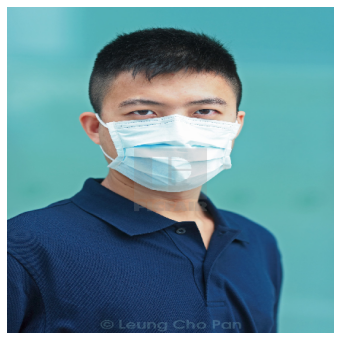

<Figure size 1080x1080 with 0 Axes>

In [ ]:
#block_size=w//s
plt_fig = show_imcv(im_test)
plt_fig.savefig('test.png', format='png', dpi='figure');

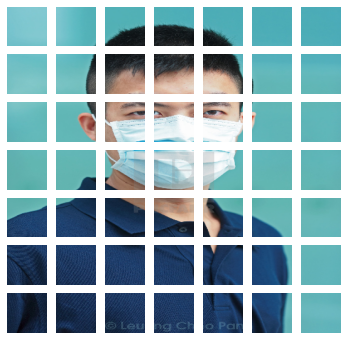

In [ ]:
im_grid,plt_fig = plot_grid(im_test, shape=(s,s))
plt_fig.savefig('test_grid.png', format='png', dpi='figure');

In [ ]:
files.download('test_grid.png')
files.download('test.png')

In [ ]:
im_fig = convert_pltfig_in_img(plt_fig, im_test.shape[:2])

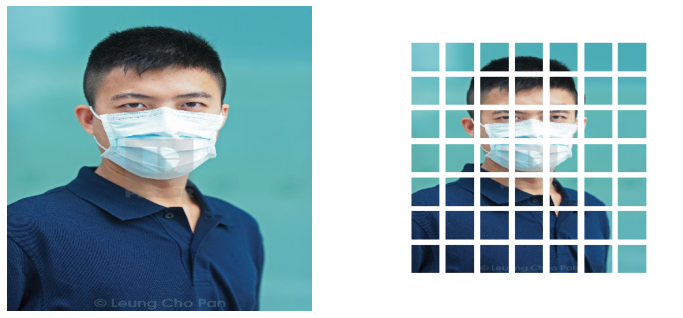

In [ ]:
plot_side([im_test, im_fig], figsize=(12,12))

# Train Model

## Training Configuration  

```bash
$ ./darknet detector train \
yolov4-face-setup.data \
yolov4-face-train.cfg \
./darknet53.conv.74 \
-dont_show -map 2> train_log.txt
```




In [13]:
print(f'Moving to {darknet_path.as_posix()}')
%cd {darknet_path.as_posix()}
!ls -Gg ./cfg/yolov4-mask*
!ls -Gg yolov4.weights
!ls -Gg class.names
!ls -Gg data_*.txt

Moving to /content/drive/My Drive/darknet
/content/drive/My Drive/darknet
-rw------- 1 12251 Jul 31 09:49 ./cfg/yolov4-mask-test.cfg
-rw------- 1 12251 Jul 31 15:00 ./cfg/yolov4-mask-train.cfg
-rw------- 1 170038676 Apr 27 12:39 yolov4.weights
-rw------- 1 12 Jul 31 09:49 class.names
-rw------- 1 21801 Jul 27 21:00 data_test.txt
-rw------- 1 85778 Jul 27 21:00 data_train.txt


In [ ]:
RESTART_DARKNET = True #@param {type:"boolean"}
if RESTART_DARKNET:
  !./darknet detector train \
yolov4-mask-setup.data \
./cfg/yolov4-mask-train.cfg \
yolov4.weights \
-dont_show -map 2> train_log.txt
else:
  !./darknet detector train \
yolov4-mask-setup.data \
./cfg/yolov4-mask-train.cfg \
./cfg/yolov4.backup \
-dont_show -map 2> train_log.txt

In [ ]:
!ls -ltr ./backup
!ls -l /tmp

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot access './backup': Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
total 4
srw------- 1 root root    0 Jul 31 13:48 drivefs_ipc.0
srw------- 1 root root    0 Jul 31 13:48 drivefs_ipc.0_shell
drwx------ 2 root root 4096 Jul 31 09:47 tmpihhq95ng


# Inference

## Inference command example  

```bash
$ !./darknet detect cfg/yolov3.cfg yolov3.weights traffic.jpg -thresh 0.5
```

## Demo

```bash
$ !./darknet detector demo yolo_mask.data yolo_mask.cfg backup/yolo_mask_best.weights test-video1.mp4 -thresh .6 -out_filename out-vid1.avi -dont_show
```

In [ ]:
im_fname = test_ds_path.as_posix() + '/p-test-image8.jpeg'
!pwd
!chmod +x darknet
!./darknet detector test \
yolov4-mask-setup.data \
./cfg/yolov4-mask-test.cfg \
backup/yolov4-mask-train_final.weights \
'{im_fname}' \
-thresh 0.6 -dont_show 2> /dev/null

In [ ]:
im_test = cv.imread(im_fname, cv.IMREAD_UNCHANGED)
print(im_fname)
plt_fig = show_imcv(im_test)

In [ ]:
im_predict_fname = darknet_path.as_posix() + '/predictions.jpg'
im_predict = cv.imread(im_predict_fname, cv.IMREAD_UNCHANGED)
print(im_predict_fname)
plt_fig = show_imcv(im_predict)

In [ ]:
#!./darknet detector demo yolov3-mask-setup.data yolov3-mask-test.cfg backup/yolov3-mask-train_final.weights {test_ds_path.as_posix()}/test-video1.mp4 -thresh .6 -out_filename out-vid1.avi -dont_show
!date

# Reference

1. YOLO site - [YOLO](https://pjreddie.com/darknet/yolo)  
2. [Teste](http://teste.com/)
